In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime
from scipy.stats import poisson
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

from tqdm import tqdm
import os
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) # Silence Prophet if nothing major happens


In [197]:
def height_to_unixepoch(height: int) -> int:
    return height * 30 + 1598306400

def height_to_timestamp(height: int) -> datetime:
    return datetime.fromtimestamp(height_to_unixepoch(height))

def unixepoch_to_height(timestamp):
    return (timestamp - 1598306400)/30

def datetime_to_height(year:int, month:int, day:int) -> float:
    dd = int(datetime(year, month, day).strftime('%s'))
    return int((dd - 1598306400)/30)

# Some overheads to suppress Prophet output
# https://github.com/facebook/prophet/issues/223#issuecomment-326455744
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)    

def interpolate_predictions(df, fcst, feature, yhat='yhat', n_days=450):
    '''
    Takes the daily predictions from Prophet and interpolates it at the epoch level.

    Parameters
    ----------
    df (pd.DataFrame): original dataframe, sampled at epoch frequency
    fcst (pd.DataFrame): output dataframe from Prophet (must have columns ds, yhat, yhat_lower, yhat_upper)
    yhat (string): whether to use Prophet's median ('yhat'), optimistic ('yhat_upper') or pessimistic ('yhat_lower') prediction
    n_days (int): number of days to predict ahead

    Returns
    -------
    df_new (pd.DataFrame): interpolates daily Prophet prediction into an epoch-wise prediction. When feature 
                           is 'raw_bytes_network_power',  this function will also calculate the network time 
                           in epoch units. 
    '''

    df_p = fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-n_days:]

    if feature == 'raw_bytes_network_power':

        assert 'raw_bytes_network_power' in df.columns, "raw_bytes_network_power not in epoch-level dataframe"

        # Populate a new epoch-wise dataframe for the forward predictions
        df_new = pd.DataFrame()
        df_new['height'] = np.arange(df.height.max(), n_days*2880+df.height.max())
        df_new['datetime'] = df_new['height'].apply(height_to_timestamp)

        # Impute the daily prediction at 12 midnight of each day
        midnight_condition = (df_new['datetime'].dt.hour == 0) & (df_new['datetime'].dt.minute == 0) & (df_new['datetime'].dt.second == 0)
        df_new['raw_bytes_network_power'] = np.nan

        midnight_idx = np.argwhere(midnight_condition.values>0).reshape(1,-1)[0]
        for i,idx in enumerate(midnight_idx):
            df_new.loc[idx, 'raw_bytes_network_power'] = df_p.iloc[-n_days:][yhat].values[i]

        # Patch the first row of the extrapolated dataframe to the last row of the actual chain data, to facilitate interpolation
        # There will therefore be 301 interpolated points in the epoch-wise extrapolated dataframe
        df_new.loc[0, 'raw_bytes_network_power'] = df['raw_bytes_network_power'].iloc[-1]
        df_new['raw_bytes_network_power'] = df_new['raw_bytes_network_power'].interpolate(method='linear', limit_direction='forward')

        dynamic_baseline = lambda epoch: df.new_baseline_power.iloc[0] * np.exp(np.log(2)/525600/2*epoch)
        g = np.log(2)/31536000*30 # the growth rate in epoch units
        b0 = 2.888888 * 2**60 / 2**50

        # Don't forget to drop the duplicate row in df_new before concat
        df_out = pd.concat([df[['height', 'datetime', 'raw_bytes_network_power']], 
                            df_new[['height', 'datetime', 'raw_bytes_network_power']].iloc[1:]]) 
        df_out = df_out.reset_index(drop=True)
        df_out['baseline_power'] = dynamic_baseline(np.arange(len(df_out)))
        df_out['cumsum_capped_rb_power'] = df_out[['raw_bytes_network_power', 'baseline_power']].min(axis=1).cumsum()
        df_out['est_network_height'] = 15410 + 1.055*np.log(df_out['cumsum_capped_rb_power']*g/b0 + 1)/g  


    else: 

        assert feature in df.columns, "%s not in epoch-level dataframe" % feature

        # Populate a new epoch-wise dataframe for the forward predictions
        df_new = pd.DataFrame()
        df_new['height'] = np.arange(df.height.max(), n_days*2880+df.height.max())
        df_new['datetime'] = df_new['height'].apply(height_to_timestamp)

        # Impute the daily prediction at 12 midnight of each day
        midnight_condition = (df_new['datetime'].dt.hour == 0) & (df_new['datetime'].dt.minute == 0) & (df_new['datetime'].dt.second == 0)
        df_new[feature] = np.nan

        midnight_idx = np.argwhere(midnight_condition.values>0).reshape(1,-1)[0]
        for i,idx in enumerate(midnight_idx):
            df_new.loc[idx, feature] = df_p.iloc[-n_days:]['yhat'].values[i]

        # Patch the first row of the extrapolated dataframe to the last row of the actual chain data, to facilitate interpolation
        # There will therefore be 301 interpolated points in the epoch-wise extrapolated dataframe
        df_new.loc[0, feature] = df[feature].iloc[-1]
        df_new[feature] = df_new[feature].interpolate(method='linear', limit_direction='forward')

        # Don't forget to drop the duplicate row in df_new before concat
        df_out = pd.concat([df[['height', 'datetime', feature]], 
                            df_new[['height', 'datetime', feature]].iloc[1:]]) 
        df_out = df_out.reset_index(drop=True)

        if feature == 'qa_bytes_network_power':
            # if the feature is QA bytes network power, re-calculate the smoothed velocity and position estimates for the entire extrapolated df

            position = df['qa_smoothed_position_estimate'].iloc[0]
            velocity = df['qa_smoothed_velocity_estimate'].iloc[1]
            dt = 1
            alpha = 0.000164
            beta = 0.000115
            qa_recalc_pos = []
            qa_recalc_vel = []
            for k in range(len(df_out)):
                position = position + velocity * dt
                velocity = velocity
                residual = df_out['qa_bytes_network_power'].iloc[k] - position
                position = position + alpha * residual
                velocity = velocity + (beta/dt) * residual
                qa_recalc_pos.append(position)
                qa_recalc_vel.append(velocity)
            df_out['qa_smoothed_position_estimate'] = qa_recalc_pos
            df_out['qa_smoothed_velocity_estimate'] = qa_recalc_vel

            df_out = df_out[['height', 'datetime', 'qa_bytes_network_power', 'qa_smoothed_position_estimate', 'qa_smoothed_velocity_estimate']]

    return df_out

def calculate_block_reward(df):

    '''
    Given a fully extrapolated epoch-level dataframe, calculate block rewards received per day. 

    Parameters
    ----------
    df (pd.DataFrame): extrapolated epoch-level dataframe

    Returns
    -------
    df (pd.DataFrame): dataframe with simple reward, baseline reward, M (minted supply target), w (reward per wincount)
    '''

    FIL_BASE = 2e9          # only this amount in FIL will ever be issued
    M_infty = 0.55*FIL_BASE # asymptotic number of tokens
    lda = np.log(2)/6       # the minting rate corresponding to a 6 year half life
    gamma = 0.7             # the minting ratio assigned to hybrid minting
    conv_factor = 525600*2  # number of epochs in a year

    df['delta_t'] = ( df['height'] - df['height'].iloc[0])
    df['delta_t_bl'] = ( df['est_network_height'] - df['est_network_height'].iloc[0])    
    df['simple_reward'] = (1-gamma)*M_infty*gamma*(1-np.exp(-lda * df['delta_t']/conv_factor))
    df['baseline_reward'] = gamma*M_infty*gamma*(1-np.exp(-lda * df['delta_t_bl']/conv_factor))
    df['M'] =  df['simple_reward'] + df['baseline_reward']
    
    # The rolling window is arbitrary
    df['M_diff'] = df['M'].diff().rolling(2880).mean() #np.gradient(df['M'].rolling(2880).mean())
    df['w'] = df['M_diff'] / 5 

    return df[['height', 'datetime', 'M', 'w']]

def ratio_extract(num_p, num_v, denom_p, denom_v, delta_T):
    '''
    Evaluate the ratio of two variables by the alpha-beta filter
    '''
    x2a = np.log(denom_p + denom_v) 
    x2b = np.log(denom_p + denom_v + denom_v * delta_T)
    m1 = denom_v * num_p * (x2b - x2a)
    m2 = num_v * (denom_p * (x2a - x2b) + denom_v * delta_T)
    return (m1 + m2) / denom_v**2    

def predict_on_dataframe(df, column_name = 'raw_bytes_network_power', n_days=450):
    dc = df[['datetime', column_name]].reset_index(drop=True)
    dc.columns = ['ds', 'y']
    
    m = Prophet(daily_seasonality=False)
    with suppress_stdout_stderr():
        m.fit(dc)
    future = m.make_future_dataframe(periods=n_days)
    fcst = m.predict(future)
    return fcst


### Circulating supply calculator

In [198]:
# 0. Load data
df = pd.read_csv('data/df_height.csv')
df['datetime'] = df['height'].apply(height_to_timestamp)

# A new dataframe that's sampled exactly at midnight
# it should occur at intervals of 2880 epochs or so 
dfc = df[(df['datetime'].dt.hour == 0) & (df['datetime'].dt.minute == 0) & (df['datetime'].dt.second == 0)]

12:16:00 - cmdstanpy - INFO - Chain [1] start processing
12:16:00 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:02 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Forward prediction of real byte network capacity')

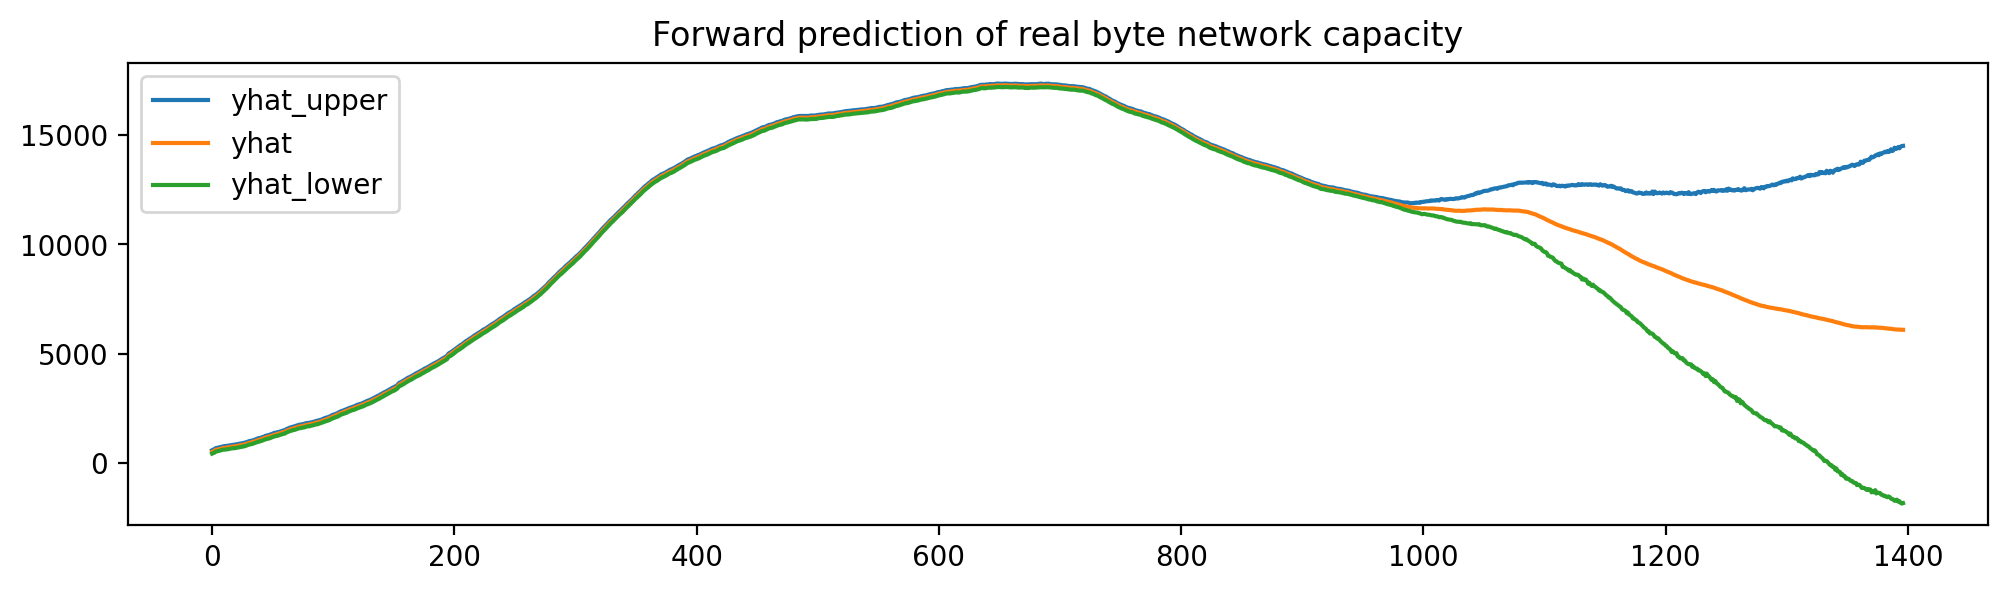

In [199]:
# 1. Run separate predictions on RB and QA network power (daily frequency)
fcst = predict_on_dataframe(dfc, 'raw_bytes_network_power')
fcst_qa = predict_on_dataframe(dfc, 'qa_bytes_network_power')
fcst_circ = predict_on_dataframe(dfc, 'circulating_fil')

fig, ax = plt.subplots(figsize=(12,3))
fcst[['yhat_upper', 'yhat', 'yhat_lower']].plot(ax=ax)
ax.set_title('Forward prediction of real byte network capacity')

In [200]:
# 2. Interpolate the predictions from daily to epoch level 
df_new = interpolate_predictions(df, fcst, 'raw_bytes_network_power')
df_new_qa = interpolate_predictions(df, fcst_qa, 'qa_bytes_network_power')
df_new_circ = interpolate_predictions(df, fcst_circ, 'circulating_fil')

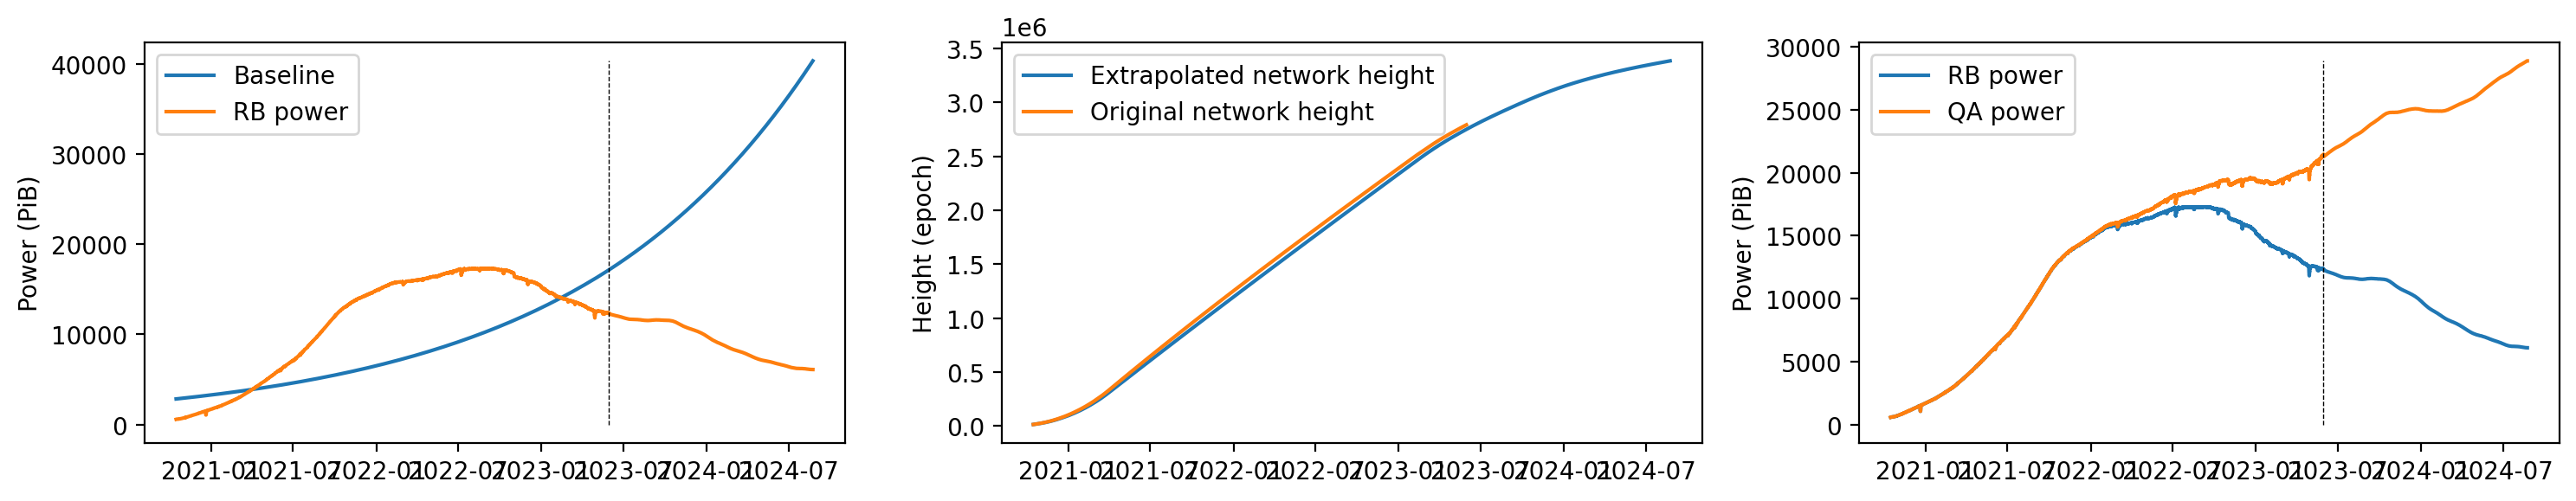

In [201]:
latest_chain_date = df.datetime.iloc[-1]

# 2a. Inspect the interpolations made 
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,3))
ax1.plot(df_new['datetime'], df_new['baseline_power'], label='Baseline')
ax1.plot(df_new['datetime'], df_new['raw_bytes_network_power'], label='RB power')
ax1.plot([latest_chain_date, latest_chain_date], [0, df_new.baseline_power.max()], 'k--', lw=0.5)
ax1.legend(loc='upper left')
ax2.plot(df_new['datetime'], df_new['est_network_height'], label="Extrapolated network height")
ax2.plot(df['datetime'], df['network_height'], label='Original network height')
ax2.legend(loc='upper left')
ax3.plot(df_new['datetime'], df_new['raw_bytes_network_power'], label='RB power')
ax3.plot(df_new_qa['datetime'], df_new_qa['qa_bytes_network_power'], label='QA power')
ax3.plot([latest_chain_date, latest_chain_date], [0, df_new_qa.qa_bytes_network_power.max()], 'k--', lw=0.5)
ax3.legend(loc='upper left')
ax1.set_ylabel('Power (PiB)')
ax2.set_ylabel('Height (epoch)')
ax3.set_ylabel('Power (PiB)')
plt.tight_layout()

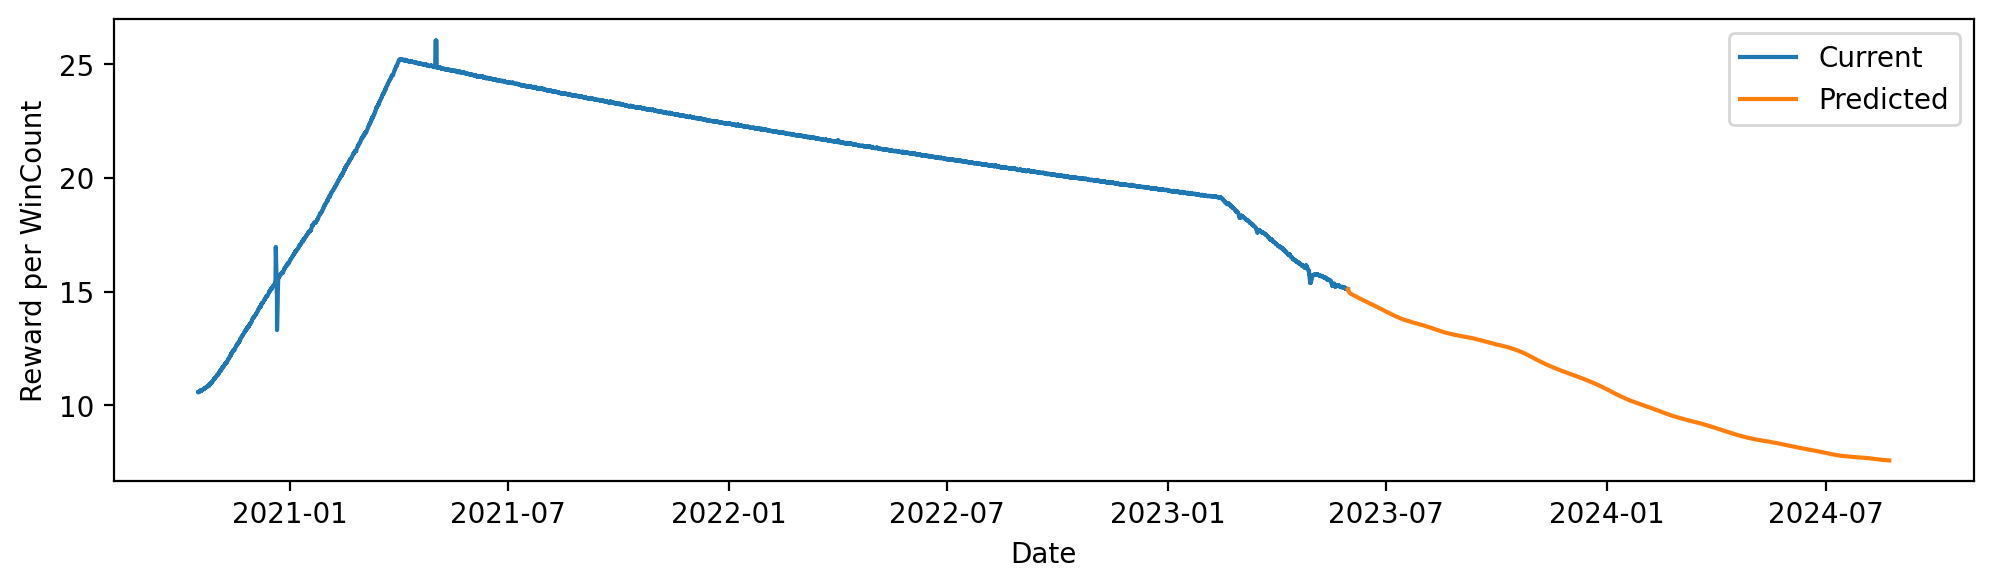

In [202]:
df_new = interpolate_predictions(df, fcst, 'raw_bytes_network_power')
df_out = calculate_block_reward(df_new)

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df_out['datetime'].iloc[0:len(df)], 1.4*df_out['w'].iloc[0:len(df)], label='Current')
ax.plot(df_out['datetime'].iloc[len(df):], 1.4*df_out['w'].iloc[len(df):], label='Predicted', color='C1')
ax.set_ylabel('Reward per WinCount')
ax.set_xlabel('Date')
ax.legend(loc='upper right')

### Calculate block rewards earned 

The block rewards earned is the reward per wincount multiplied by the wincount per epoch.

In [277]:
block_reward_earned_hist = 1.4*df_out['w'].iloc[0:len(df)] * df.win_count
block_reward_earned_fwd = 1.4*df_out['w'].iloc[len(df):] * poisson.rvs(5, size=len(df_out)-len(df))
df_block_reward = pd.DataFrame(np.array([df_out.height.values, np.concatenate([block_reward_earned_hist, block_reward_earned_fwd])]).T, columns=['height', 'block_reward']).fillna(0)
df_block_reward['datetime'] = df_block_reward['height'].apply(height_to_timestamp).dt.date
df_block_reward['reward_cum'] = df_block_reward.block_reward.cumsum()
del block_reward_earned_hist, block_reward_earned_fwd

# df_block_reward['immediate_reward'] = 0.25 * df_block_reward['block_reward']
# df_block_reward['vested_reward'] = 0
# df_block_reward['stat_date'] = df_block_reward['height'].apply(height_to_timestamp).dt.date
# df_block_reward_day = df_block_reward.groupby('stat_date')[['immediate_reward', 'vested_reward']].sum().reset_index()
# del block_reward_earned_hist, block_reward_earned_fwd, df_block_reward

# for i in range(len(df_block_reward_day)):
#     df_block_reward_day['vested_reward'].iloc[i: np.min([i+180, len(df_block_reward_day)])] += df_block_reward_day['immediate_reward'].iloc[i]*3/180

# df_block_reward_day['total_reward'] = df_block_reward_day['immediate_reward'] + df_block_reward_day['vested_reward'] 

### Vesting schedule

In [278]:
df_block_reward['vested'] = 0
df_block_reward['vested'].iloc[0] += 10632000
df_block_reward['vested'].iloc[0:np.min([183*2880, len(df_block_reward)])] += np.ones(np.min([183*2880, len(df_block_reward)])) * (19015887 + 32787700) / 183/2880
df_block_reward['vested'].iloc[0:np.min([1*365*2880, len(df_block_reward)])] += np.ones(np.min([365*2880, len(df_block_reward)])) * (22421712 + 9400000) / 365/2880
df_block_reward['vested'].iloc[0:np.min([2*365*2880, len(df_block_reward)])] += np.ones(np.min([2*365*2880, len(df_block_reward)])) * (7223364) / 365/2/2880
df_block_reward['vested'].iloc[0:np.min([3*365*2880, len(df_block_reward)])] += np.ones(np.min([3*365*2880, len(df_block_reward)])) * (87637883 + 898958) / 365/3/2880
df_block_reward['vested'].iloc[0:np.min([6*365*2880, len(df_block_reward)])] += np.ones(np.min([6*365*2880, len(df_block_reward)])) * (400000000 + 9805053) / 365/3/2880
df_block_reward['vested'] = df_block_reward['vested'].cumsum()

df_block_reward['disbursed'] = 17066618.9617734

/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_14642/1525517651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_block_reward['vested'].iloc[0] += 10632000
/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_14642/1525517651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_block_reward['vested'].iloc[0:np.min([183*2880, len(df_block_reward)])] += np.ones(np.min([183*2880, len(df_block_reward)])) * (19015887 + 32787700) / 183/2880


Text(0, 0.5, 'Amount (million FIL)')

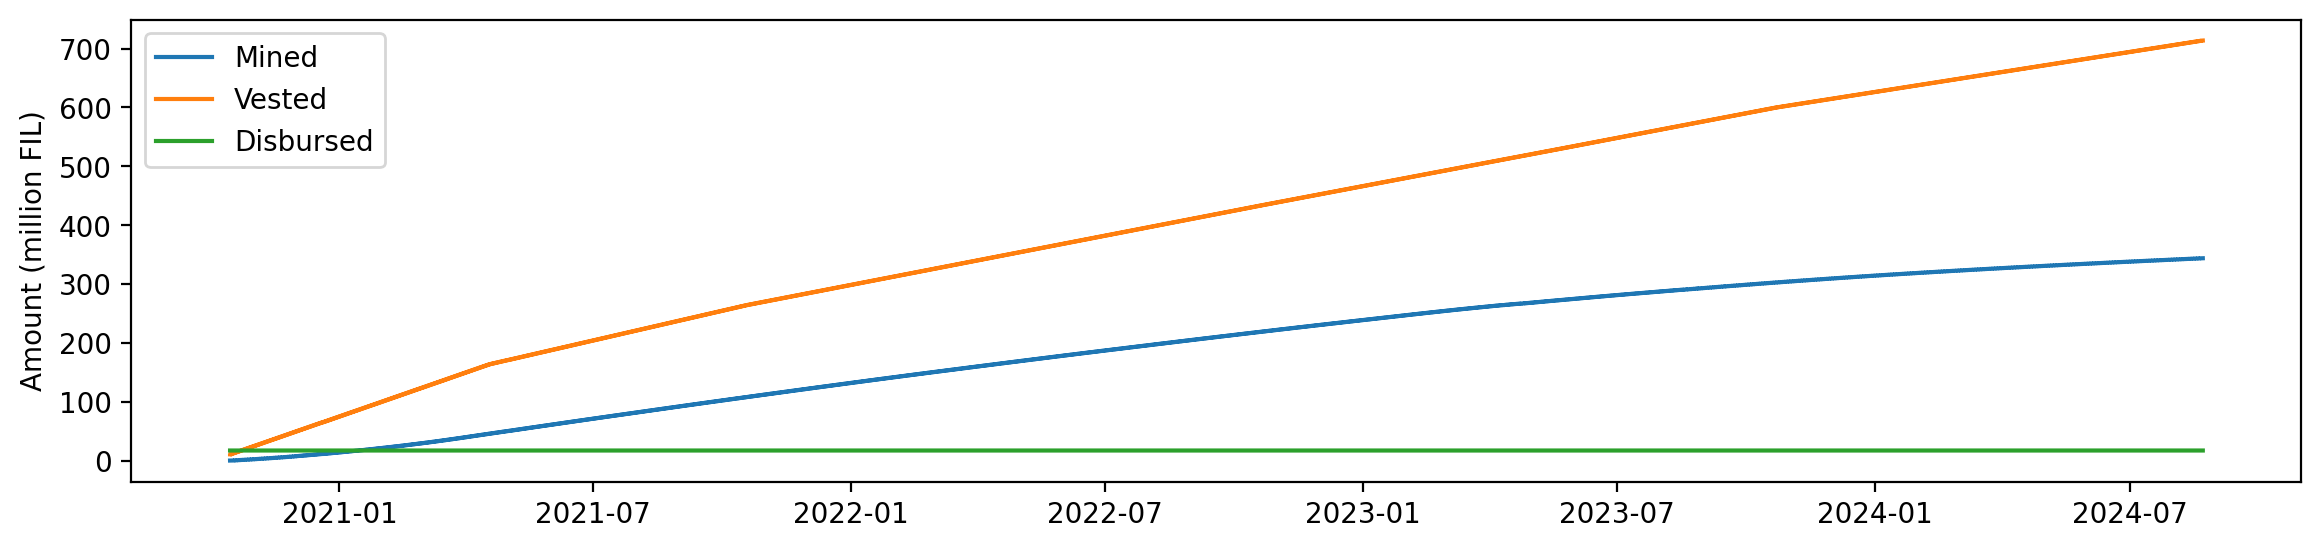

In [279]:
plt.figure(figsize=(14,3))
plt.plot(df_block_reward.datetime, df_block_reward.reward_cum/1e6, label='Mined')
plt.plot(df_block_reward.datetime, df_block_reward.vested/1e6, label='Vested')
plt.plot(df_block_reward.datetime, df_block_reward.disbursed/1e6, label='Disbursed')
plt.legend()
plt.ylabel('Amount (million FIL)')

In [280]:
df_cs_agg = df_block_reward.groupby('datetime').mean()[['reward_cum', 'vested', 'disbursed']].reset_index()
df_cs_agg.datetime = df_cs_agg.datetime.astype('datetime64')

In [281]:
data_cs = pd.read_csv('data/FIL_Protocol_Circulating_Supply.csv')
data_cs = data_cs.rename(columns={'stateTime': 'datetime'})
data_cs_locked = predict_on_dataframe(data_cs, 'Total FIL Burned')
data_cs_burned = predict_on_dataframe(data_cs, 'Total FIL Locked')
locked_df = data_cs_locked[['ds', 'yhat']]
locked_df.columns = ['datetime', 'locked']
locked_df['locked'] *= 1e6
burned_df = data_cs_burned[['ds', 'yhat']]
burned_df.columns = ['datetime', 'burned']
burned_df['burned'] *= 1e6


13:37:01 - cmdstanpy - INFO - Chain [1] start processing
13:37:01 - cmdstanpy - INFO - Chain [1] done processing
13:37:02 - cmdstanpy - INFO - Chain [1] start processing
13:37:02 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_14642/771069271.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locked_df['locked'] *= 1e6
/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_14642/771069271.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burn

In [292]:
df_cs_final = pd.merge(df_cs_agg, locked_df)
df_cs_final = pd.merge(df_cs_final, burned_df)
df_cs_final.index = df_cs_final.datetime
df_cs_final = df_cs_final.rename(columns={'reward_cum': 'mined'})

/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_14642/2669440302.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cs_final.sum(axis=1).plot(ax=ax2)


Text(0, 0.5, 'Circulating supply')

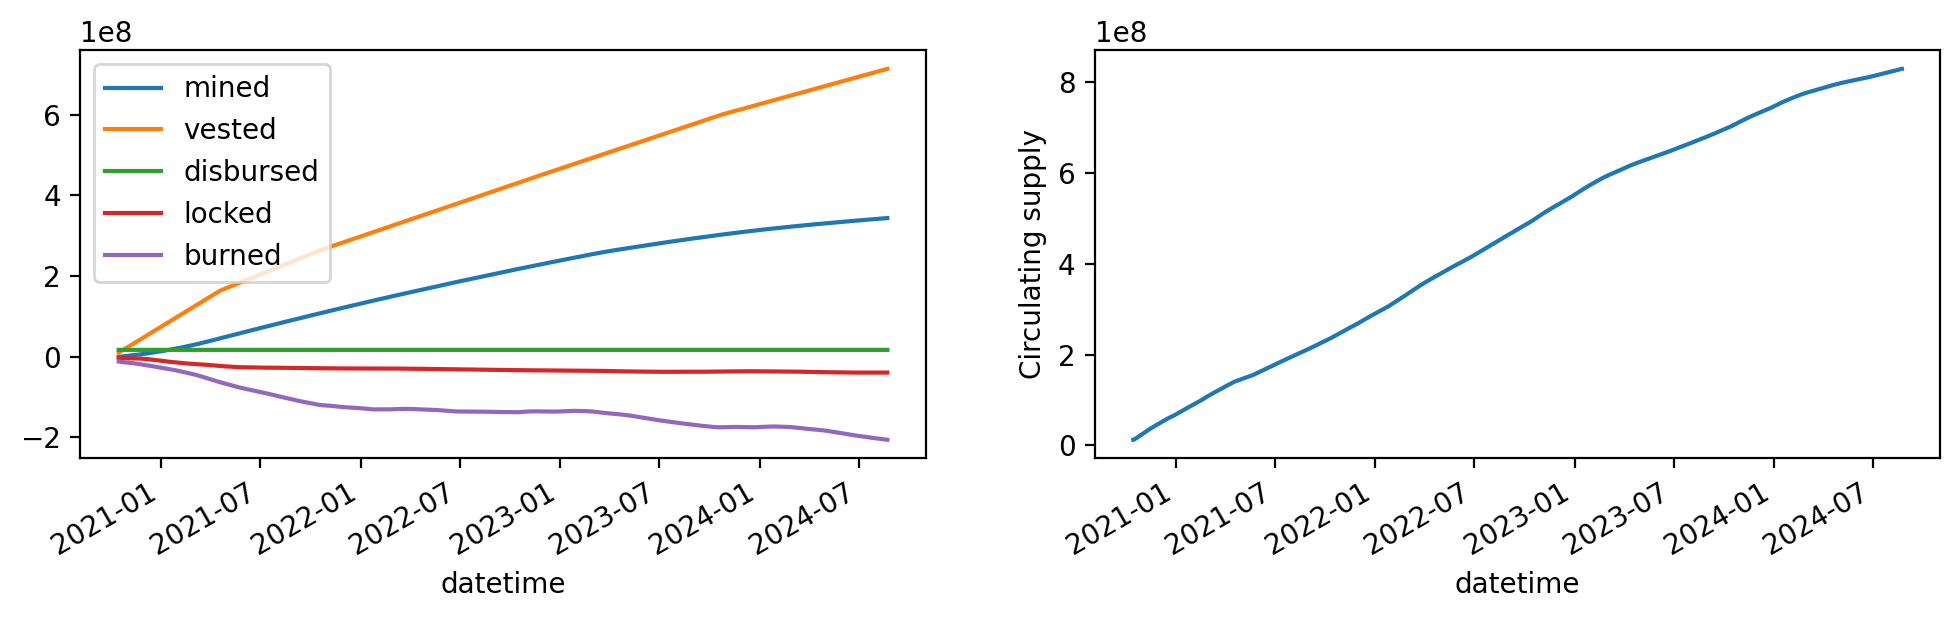

In [293]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
df_cs_final[df_cs_final.columns[1:]].plot(ax=ax1)
df_cs_final.sum(axis=1).plot(ax=ax2)
ax2.set_ylabel('Circulating supply')
